In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import scipy
import ECoG

In [2]:
import time

In [3]:
import pandas as pd

In [4]:
x,y = ECoG.read_ECoG_from_csv("ECoG.csv","Motion.csv")

In [ ]:
X = pd.read_csv('Sig.csv')

In [9]:
Y = pd.read_csv('Motion_prepr.csv')

In [5]:
data = ECoG.ECoG(x,y,downsample = True)
filtered = data.bandpass_filter(lowcut=0.2,highcut=60,fs = 100,inplace=True) 

In [6]:
%%time
freq = np.linspace(1,14.5,10)
scalo_pw, motion_pw,time_pw = data.scalo(1,freq,start = 0,end = 100000) # preprocess first 3000(30 sec) objects of 

Wall time: 37min 2s


In [7]:
scalo_pw.shape

(99880, 32, 10, 12)

In [8]:
X = scalo_pw.reshape((scalo_pw.shape[0],scalo_pw.shape[1]*scalo_pw.shape[2]*scalo_pw.shape[3]))

In [34]:
X.shape

(99880, 3840)

In [35]:
signal_df =pd.DataFrame(X,index = time_pw)
motion_df = pd.DataFrame(motion_pw, index = time_pw, columns=['X','Y','Z'])

In [181]:
X.shape

(29880, 3200)

In [36]:
signal_df.to_csv('Sig.csv')
motion_df.to_csv('Motion_prepr.csv')

In [9]:
X = (X - X.mean())/X.std()
for i in range(3):
    motion_pw[:,i] = (motion_pw[:,i] - motion_pw[:,i].mean())/motion_pw[:,i].std()

In [95]:
motion_pw.mean()

8.821853129545103e-17

In [10]:
X_train = X[:70000,:]
Y_train = motion_pw[:70000,:]
Y_test = motion_pw[70000:,:]
X_test = X[70000:,:]

In [11]:
model = PLSRegression(n_components = 20)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
Y_pred_test = model.predict(X_test)

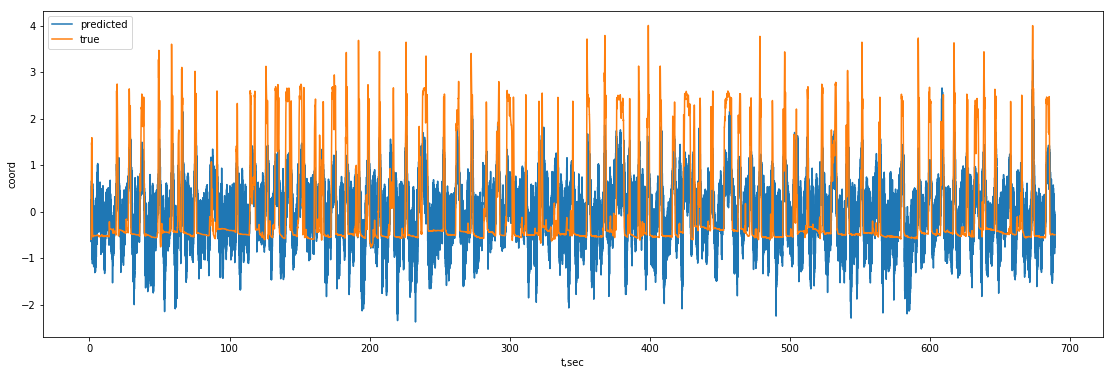

In [12]:
plt.figure(figsize = (19,6))
plt.plot(time_pw[:70000],Y_pred[:,2],label = 'predicted')
plt.plot(time_pw[:70000],Y_train[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


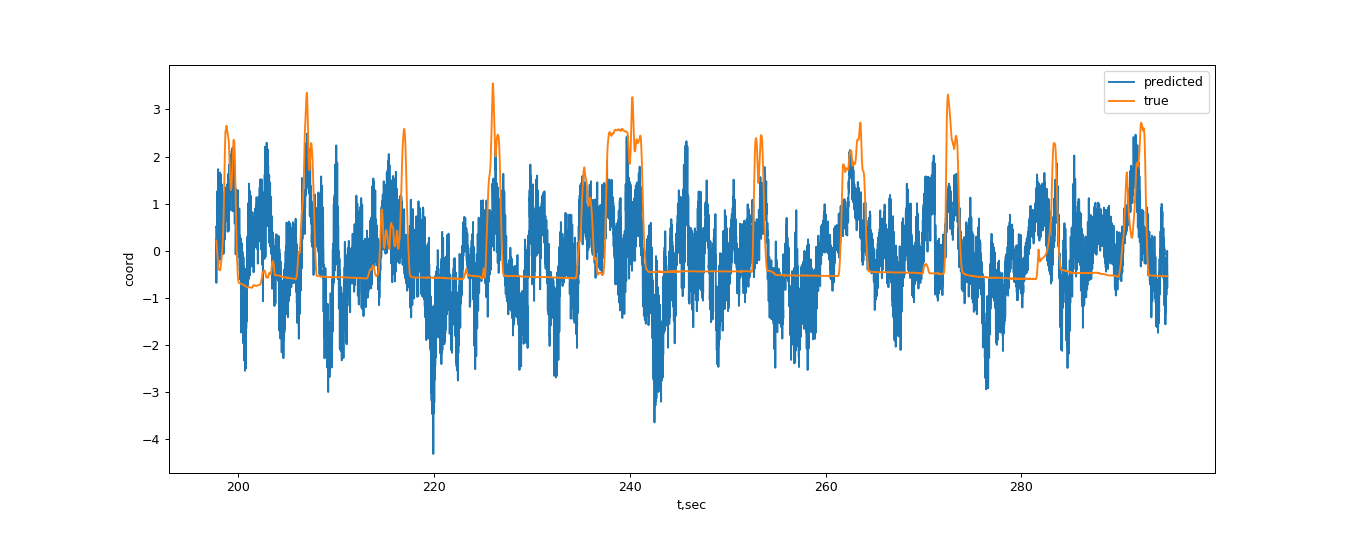

In [185]:
plt.figure(figsize = (15,6))
plt.plot(time_pw[70000:],Y_pred_test[:,2],label = 'predicted')
plt.plot(time_pw[70000:],Y_test[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import r2_score

In [13]:
scipy.stats.pearsonr(Y_test[:,0],Y_pred_test[:,0])

(0.31103696636729239, 0.0)

In [14]:
scipy.stats.pearsonr(Y_train[:,2],Y_pred[:,2])

(0.60891756365891347, 0.0)

In [24]:
import pywt

## Try normal distribution features

In [15]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
def normal_features(signal,centers):#signal is 32x1, centers 32x2
    
    M = np.dot(centers.T,signal)/np.sum(signal)
    cov = np.cov(centers.T,aweights=signal)
    return np.array([M[0],M[1],cov[0,0],cov[0,1],cov[1,1]])

In [17]:
centers = np.array([[187,168],[190,126],[225,180],[229,141],[264,227],[264,193],[266,152],[282,215],[303,236],
              [303,198],[306,155],[325,221],[325,178],[323,136],[343,246],[349,205],[347,162],[340,120],[365,230],
             [365,185],[362,143],[386,212],[385,164],[380,122],[400,233],[405,190],[405,147],[420,214],[424,165],[424,125],
              [455,165],[460,125]],dtype = 'float')
sig = np.abs(x[0,1:])
centers[:,0] = (centers[:,0] - centers[:,0].mean())/centers[:,0].std()
centers[:,1] = (centers[:,1]  -centers[:,1].mean())/centers[:,1].std()

In [125]:
norm = normal_features(sig,centers)

In [126]:
def gaussian(args,x):
    res = np.empty((x.shape[0]))
    
    M = args[0:2]
    cov = args[2:5]
    Sigma = np.array([[cov[0],cov[1]],[cov[1],cov[2]]])
    B = 1#1/(2*np.pi*np.linalg.det(Sigma))
    for i in range(x.shape[0]):
        x0 = x[i,:]
        x0 = x0 - M
        res[i] = B * np.exp( -0.5 * np.dot(x0,np.dot(np.linalg.inv(Sigma),x0.T)))
       # print(res[i])
    return res


<IPython.core.display.Javascript object>


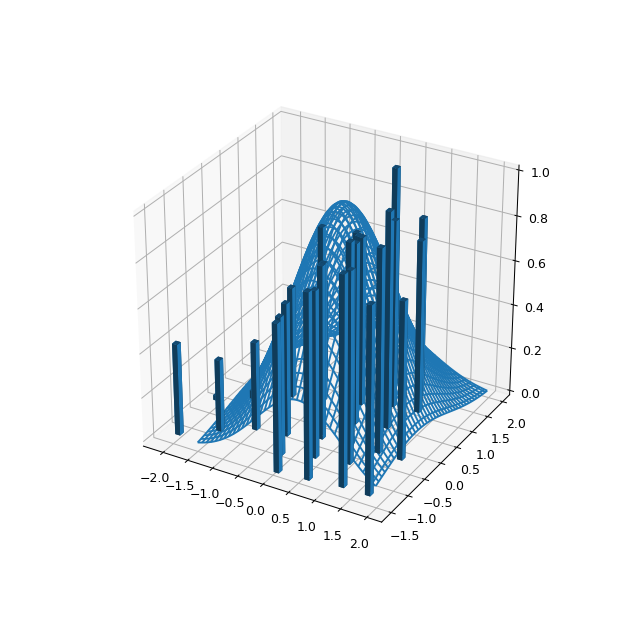

In [127]:
%matplotlib notebook
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
Z = sig
ax.bar3d(centers[:,0], centers[:,1],np.zeros(32),0.1,0.1,Z/max(Z))


x, y = np.mgrid[-1.5:2.0:0.03, -1.5:2.0:0.03]
xy = np.column_stack([x.flat, y.flat])
z_gaus = gaussian(norm,xy)
z_gaus = z_gaus.reshape(x.shape)
ax.plot_wireframe(x,y,z_gaus)
#print(np.linalg.norm(Z/100 - gaussian(args,centers)))

In [18]:
scalo_pw = scalo_pw[:,:,:,1:-1]

In [19]:
%%time
Norm = np.empty((scalo_pw.shape[0],10,scalo_pw.shape[2],scalo_pw.shape[3]))
for i in range(scalo_pw.shape[0]):
    for j in range(scalo_pw.shape[2]):
        for k in range(1,scalo_pw.shape[3]-1):
            norm_der = (normal_features(scalo_pw[i,:,j,k+1],centers) - normal_features(scalo_pw[i,:,j,k-1],centers))/(0.2)
            Norm[i,:,j,k] = np.hstack((normal_features(scalo_pw[i,:,j,k],centers),norm_der))

Wall time: 24min 33s


In [180]:
norm_der

array([-0.46325033, -1.19640515,  0.89957002,  0.56840743,  0.07874573])

In [20]:
X_norm = Norm.reshape((Norm.shape[0],Norm.shape[1]*Norm.shape[2]*Norm.shape[3]))

In [167]:
X_all = np.hstack((X,X_norm))

In [168]:
time = Y[Y.columns[0]].values

In [169]:
motion_pw = Y[Y.columns[1:]].values

In [170]:
for i in range(3):
    motion_pw[:,i] = (motion_pw[:,i] - motion_pw[:,i].mean())/motion_pw[:,i].std()

In [171]:
X_train = X_all[:20000,:]
Y_train = motion_pw[:20000,:]
Y_test = motion_pw[20000:,:]
X_test = X_all[20000:,:]

In [172]:
model = PLSRegression(n_components = 70)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
Y_pred_test = model.predict(X_test)

<IPython.core.display.Javascript object>


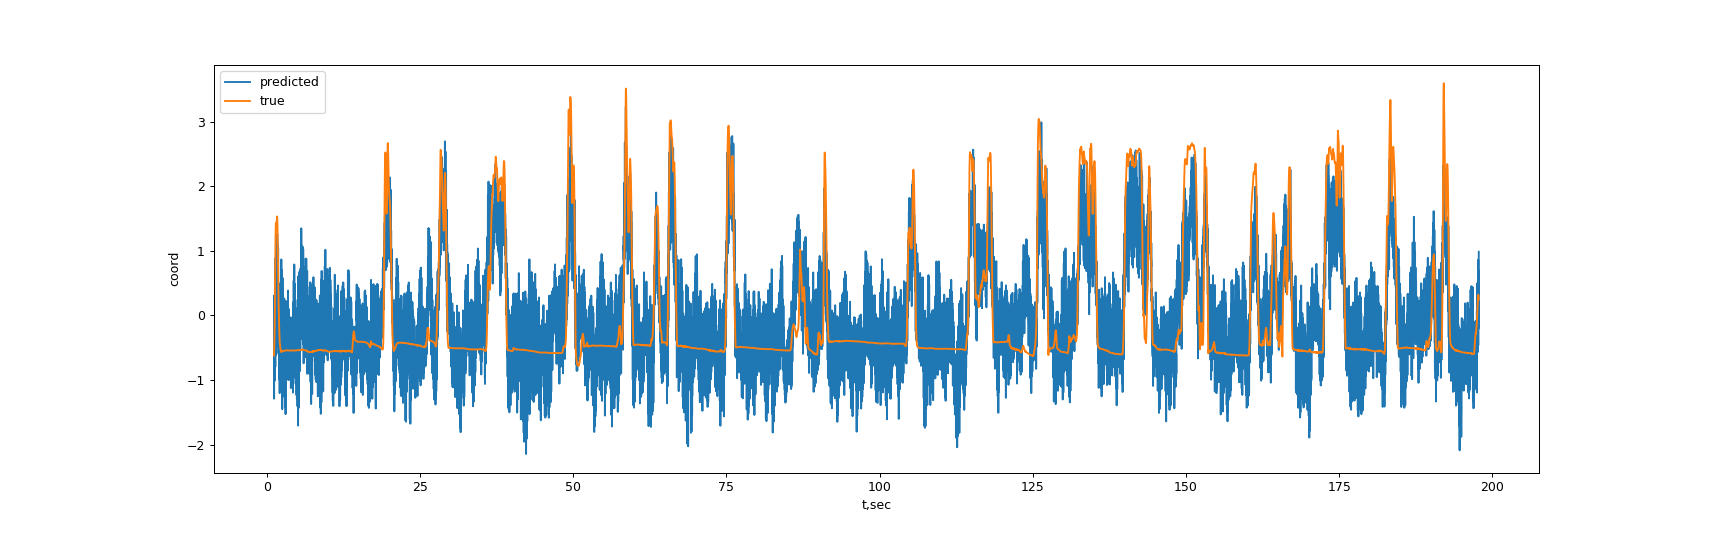

In [173]:
plt.figure(figsize = (19,6))
plt.plot(time_pw[:20000],Y_pred[:,2],label = 'predicted')
plt.plot(time_pw[:20000],Y_train[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


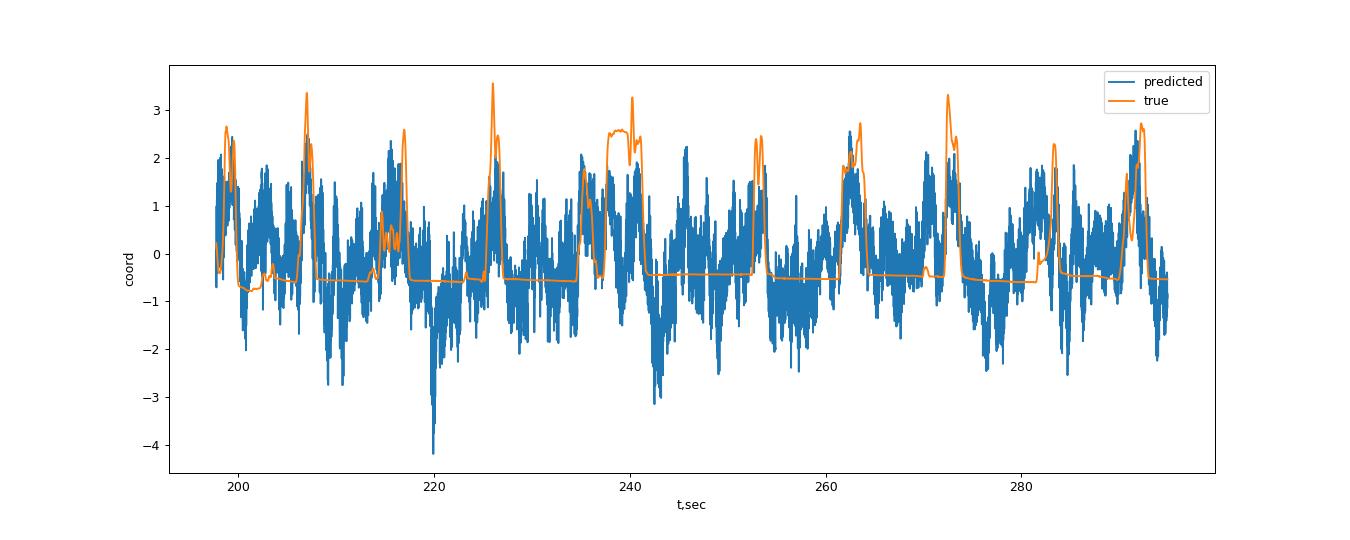

In [179]:
plt.figure(figsize = (15,6))
plt.plot(time_pw[20000:],Y_pred_test[:,2],label = 'predicted')
plt.plot(time_pw[20000:],Y_test[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

In [178]:
scipy.stats.pearsonr(Y_test[:,2],Y_pred_test[:,2])

(0.48143534586702147, 0.0)

In [176]:
scipy.stats.pearsonr(Y_train[:,2],Y_pred[:,2])

(0.8108290477217845, 0.0)

In [ ]:
def normal_features_deriv(signal,centers):#signal is 32x1, centers 32x2
    
    M = np.dot(centers.T,signal)/np.sum(signal)
    cov = np.cov(centers.T,aweights=signal)
    return np.array([M[0],M[1],cov[0,0],cov[0,1],cov[1,1]])

In [195]:
X_norm.shape

(29880, 1000)

In [21]:
X_train = X_norm[:80000,:]
Y_train = motion_pw[:80000,:]
Y_test = motion_pw[80000:,:]
X_test = X_norm[80000:,:]

In [22]:
model = PLSRegression(n_components = 50)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
Y_pred_test = model.predict(X_test)

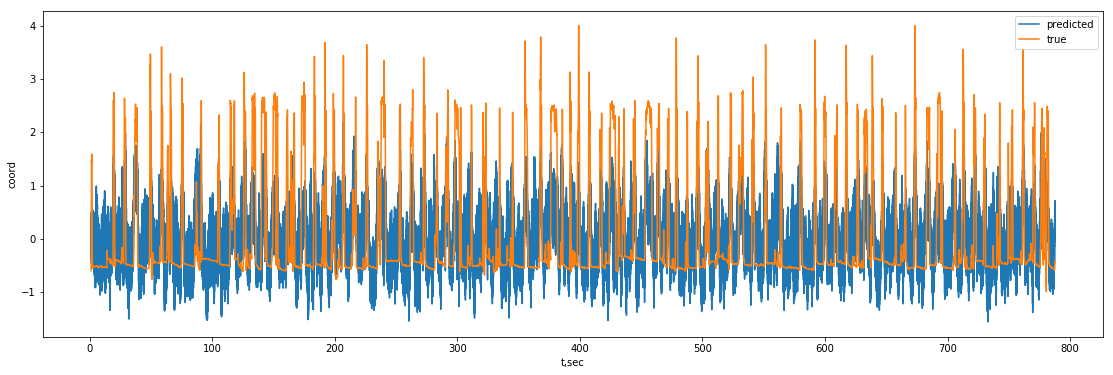

In [23]:
plt.figure(figsize = (19,6))
plt.plot(time_pw[:80000],Y_pred[:,2],label = 'predicted')
plt.plot(time_pw[:80000],Y_train[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

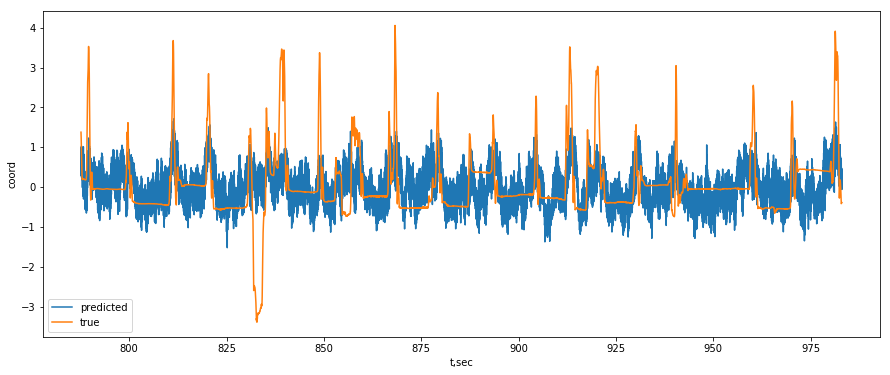

In [33]:
plt.figure(figsize = (15,6))
plt.plot(time_pw[80000:],Y_pred_test[:,0],label = 'predicted')
plt.plot(time_pw[80000:],Y_test[:,0],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

In [30]:
scipy.stats.pearsonr(Y_test[:,0],Y_pred_test[:,0])

(0.34179808999416417, 0.0)

In [26]:
scipy.stats.pearsonr(Y_train[:,1],Y_pred[:,1])

(0.46249053681737096, 0.0)

In [201]:
%%time
Norm2 = np.empty((scalo_pw.shape[0],15,scalo_pw.shape[2],scalo_pw.shape[3]))
for i in range(scalo_pw.shape[0]):
    for j in range(scalo_pw.shape[2]):
        for k in range(1,scalo_pw.shape[3]-1):
            norm_der = (normal_features(scalo_pw[i,:,j,k+1],centers) - normal_features(scalo_pw[i,:,j,k-1],centers))/(0.2)
            norm_2_der = (normal_features(scalo_pw[i,:,j,k+1],centers) - 2 * normal_features(scalo_pw[i,:,j,k],centers)
                          + normal_features(scalo_pw[i,:,j,k-1],centers))/(0.02)
            Norm2[i,:,j,k] = np.hstack((normal_features(scalo_pw[i,:,j,k],centers),norm_der,norm_2_der))

Wall time: 21min 23s


In [205]:
X_norm2 = Norm2.reshape((Norm2.shape[0],Norm2.shape[1]*Norm2.shape[2]*Norm2.shape[3]))

In [206]:
X_train = X_norm2[:20000,:]
Y_train = motion_pw[:20000,:]
Y_test = motion_pw[20000:,:]
X_test = X_norm2[20000:,:]

In [207]:
model = PLSRegression(n_components = 70)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
Y_pred_test = model.predict(X_test)

<IPython.core.display.Javascript object>


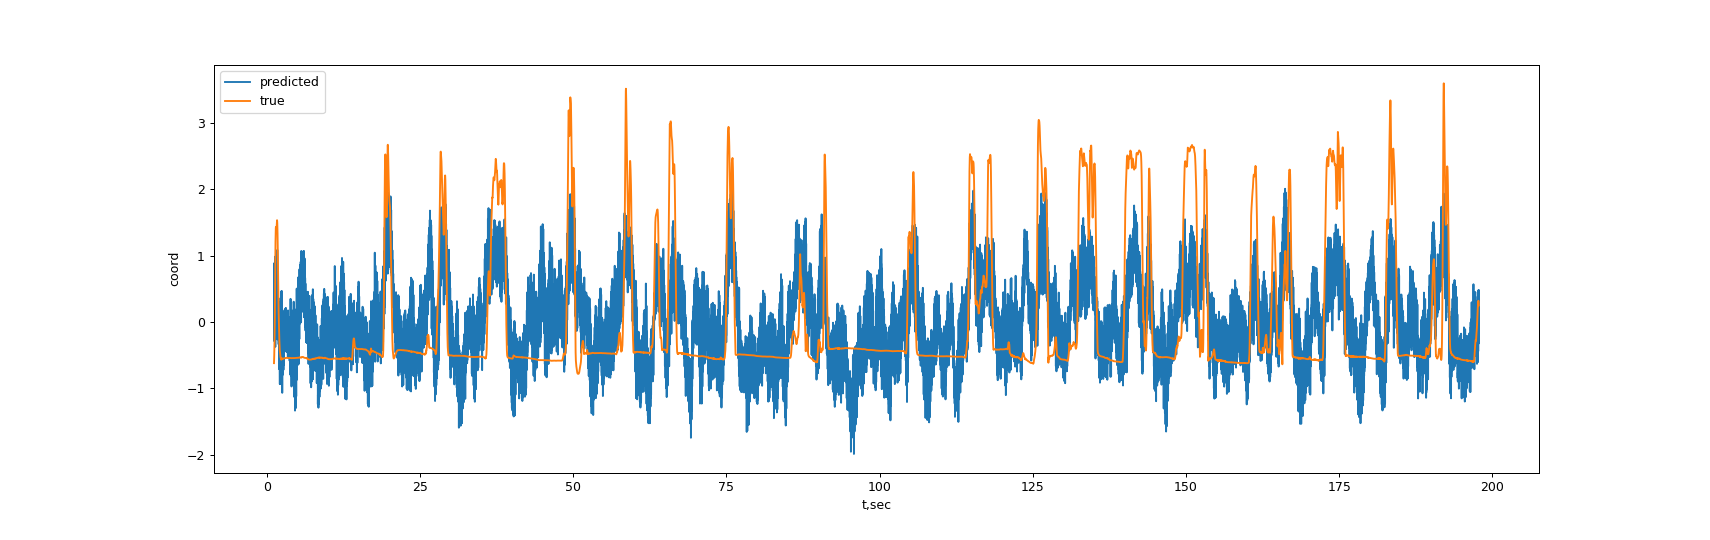

In [208]:
plt.figure(figsize = (19,6))
plt.plot(time_pw[:20000],Y_pred[:,2],label = 'predicted')
plt.plot(time_pw[:20000],Y_train[:,2],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


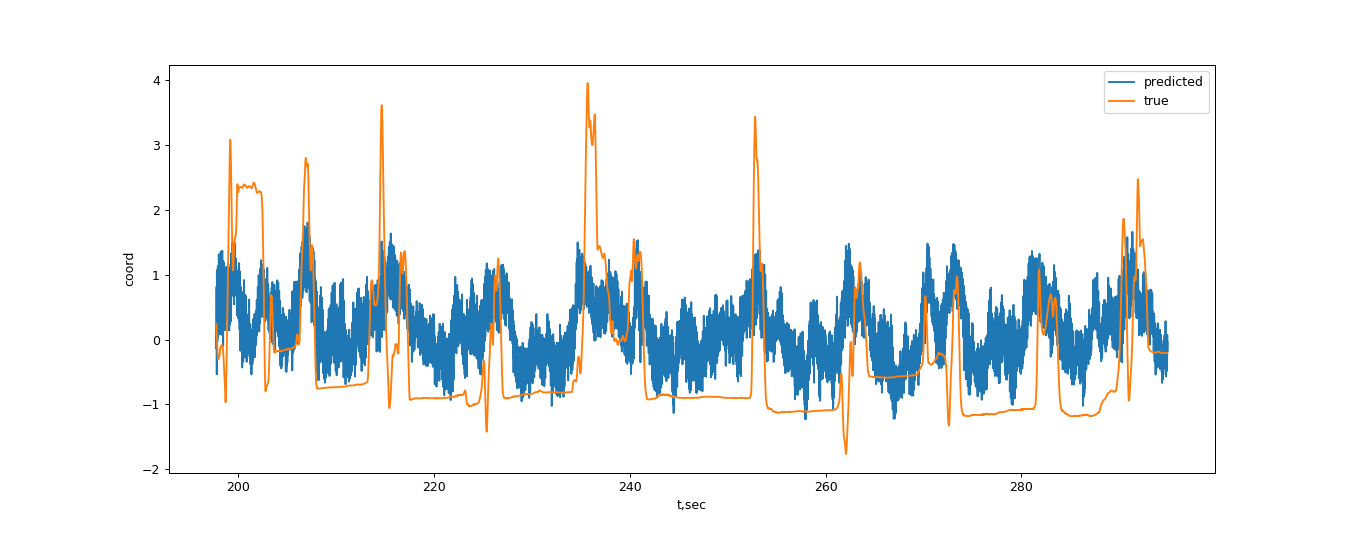

In [209]:
plt.figure(figsize = (15,6))
plt.plot(time_pw[20000:],Y_pred_test[:,1],label = 'predicted')
plt.plot(time_pw[20000:],Y_test[:,1],label = 'true')
plt.xlabel('t,sec')
plt.ylabel('coord')
plt.legend()
plt.show()

In [211]:
scipy.stats.pearsonr(Y_test[:,2],Y_pred_test[:,2])

(0.465140701227917, 0.0)

In [215]:
scipy.stats.pearsonr(Y_train[:,0],Y_pred[:,0])

(0.5520934254477408, 0.0)

In [223]:

scipy.stats.pearsonr(Y_test[:,2],np.ones(Y_test[:,2].shape)*(Y_test[:,2].mean()))

(-1.736213097079789e-17, 1.0)

In [222]:
print(np.ones(Y_test[:,2].shape)*(Y_test[:,2].mean()))

[-0.00911058 -0.00911058 -0.00911058 ... -0.00911058 -0.00911058
 -0.00911058]


In [224]:
from sklearn.metrics import r2_score

In [230]:
r2_score(Y_test[:,0],Y_pred_test[:,0])

0.15187210865755385

In [37]:
import numpy as np

In [38]:
a = np.zeros((4,3,2,2))

In [39]:
for i in range(4):
    a[i,:,:,:] = i